### Covariance analyses on Marius' V1 receptive field data. 
The receptive fields were calculated in response to discrete hartley basis functions

In [8]:
import numpy as np
import matplotlib.pyplot as plt

#### Load data and select cells with snr > 1

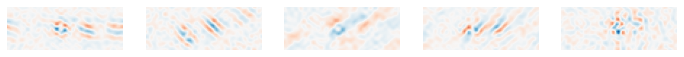

In [9]:
from data_fns import load_V1_Marius_DHT

data_dir = 'data/V1_data_Marius/'
rf_data, snr, dim = load_V1_Marius_DHT(data_dir, centered=True, normalized=True)
rf = rf_data[snr > 1]
num_cells = rf.shape[0]

fig = plt.figure(figsize=(12, 5))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    i = np.random.randint(len(rf))
    plt.imshow(rf[i].reshape(30, 80), cmap='RdBu')
    plt.clim(-10, 10)
    plt.axis('off')

#### Compute covariance from data and fit optimal hyperparameters

In [10]:
# fit optimal hyperparams to data
from estimator import  V1_inspired_kernel_matrix
import numpy.linalg as la
from scipy.optimize import minimize

# compute data covariance
cov_data = rf.T @ rf
cov_data *= cov_data.shape[1] / np.trace(cov_data)

# find params that minimize frobenius norm difference between data and covariance model
def frob_norm_diff(x):
    cov_model = V1_inspired_kernel_matrix(N=dim, s=x[0], f=x[1], center=(15, 40), scale=1)
    return la.norm(cov_data - cov_model)

x0 = [10, 2]
minimize_diff = minimize(frob_norm_diff, x0, method='BFGS', tol=1e-4)
s_min, f_min = minimize_diff.x
print('Optimal params: s=%0.2f, f=%0.2f' % (s_min, f_min))

Optimal params: s=10.19, f=1.18


(-0.5, 2399.5, 2399.5, -0.5)

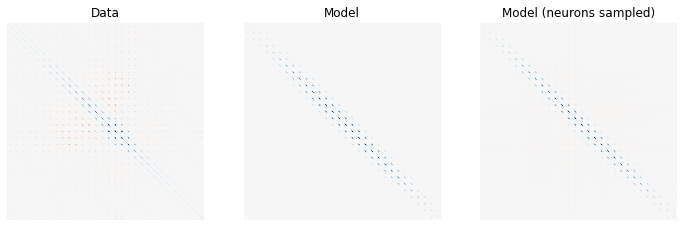

In [11]:
## generate covariance models
from estimator import V1_inspired_weights_same_center

# model
cov_model = V1_inspired_kernel_matrix(dim, s=s_min, f=f_min, center=(15, 40), scale=1)

# cov from sampled neurons
W = V1_inspired_weights_same_center(num_cells, dim, s=s_min, f=f_min, center=(15, 40), scale=1)
W = (W - np.mean(W, axis=1).reshape(-1, 1)) / np.std(W, axis=1).reshape(-1, 1)
cov_sampled_neurons = W.T @ W
cov_sampled_neurons *= cov_sampled_neurons.shape[0] / np.trace(cov_sampled_neurons).reshape(-1, 1)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(131)
plt.title('Data')
plt.imshow(cov_data, cmap='RdBu')
plt.clim(-1.5, 1.5)
plt.axis('off')
# plt.xlim(200, 500)
# plt.ylim(200, 500)

ax = fig.add_subplot(132)
plt.title('Model')
plt.imshow(cov_model, cmap='RdBu')
plt.clim(-1, 1)
plt.axis('off')
# plt.xlim(200, 500)
# plt.ylim(200, 500)

ax = fig.add_subplot(133)
plt.title('Model (neurons sampled)')
plt.imshow(cov_sampled_neurons, cmap='RdBu')
plt.clim(-1, 1)
plt.axis('off')
# plt.xlim(200, 500)
# plt.ylim(200, 500)
# plt.savefig('results/V1_data/cov_mat_fitted_Marius_DHT.pdf')

#### plot a few receptive fields

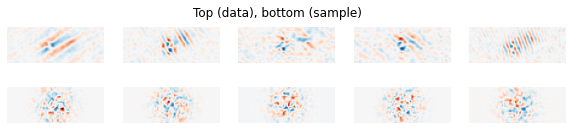

In [12]:
fig = plt.figure(figsize=(10, 2))
plt.suptitle('Top (data), bottom (sample)')
for i in range(5):
    idx = np.random.randint(num_cells)
    ax = fig.add_subplot(2, 5, i + 1)
    cell_rf = rf[idx].reshape(30, 80) 
    plt.imshow(cell_rf, cmap='RdBu')
    plt.clim([-8, 8])
    plt.axis('off')
    
    
    ax = fig.add_subplot(2, 5, 5 + i + 1)
    cell_rf = W[idx].reshape(30, 80) 
    plt.imshow(cell_rf, cmap='RdBu')
    plt.clim([-8, 8])
    plt.axis('off')
# plt.savefig('results/V1_data/receptive_fields_Marius_DHT.pdf')

#### generate covariance with fine discretization for spectral analysis

In [13]:
# plot the V1 covariance matrix with finer mesh
from scipy.spatial.distance import pdist, squareform
import numpy.linalg as la 

dim = (30, 80)
center = [15, 40]
s, f, scale = s_min, f_min, 1

x = np.arange(0, dim[0], 0.5)
y = np.arange(0, dim[1], 0.5)
yy, xx = np.meshgrid(y, x)
grid = np.column_stack((xx.flatten(), yy.flatten()))

a = squareform(pdist(grid, 'sqeuclidean'))
b = la.norm(grid - center, axis=1) ** 2
c = b.reshape(-1, 1)
cov_model_fine = np.exp(-a / (2 * f ** 2)) * np.exp(-b / (2 * s ** 2)) * np.exp(-c / (2 * s ** 2))
cov_model_fine += 1e-5 * np.eye(len(cov_model_fine))
cov_model_fine *= (scale * cov_model_fine.shape[0] / np.trace(cov_model_fine))

# generate weights
L = la.cholesky(cov_model_fine)
W_fine = np.dot(L, np.random.randn(cov_model_fine.shape[0], num_cells)).T
W_fine = (W_fine - np.mean(W_fine, axis=1).reshape(-1, 1)) / np.std(W_fine, axis=1).reshape(-1, 1)
cov_sampled_neurons_fine = W_fine.T @ W_fine
cov_sampled_neurons_fine *= (cov_sampled_neurons_fine.shape[0] / np.trace(cov_sampled_neurons_fine))

#### Compute eigenvalues and eigenvectors

In [18]:
# generate eigenfunctions and eigenvalues from the covariance matrices
eval_data, evec_data = la.eigh(cov_data)
eval_model, evec_model = la.eigh(cov_model_fine)
eval_sampled_neurons, evec_sampled_neurons = la.eigh(cov_sampled_neurons_fine)

#### define the analytical form of the eigenfunctions and eigenvalues

In [19]:
from scipy.special import eval_hermitenorm
def phi(x, s, f, k):
    ''' Orthonormal eigenfunctions of the V1 kernel in 1d'''
    alpha, beta = 1 / (2 * f ** 2), 1 / (2 * s ** 2)
    D = np.sqrt(beta ** 2 + 2 * alpha * beta)
    C = np.sqrt(2 * D)
    normalization_fac = 2 ** k * np.math.factorial(k) * np.sqrt(np.pi) / C
    return np.exp(- D * x ** 2) * eval_hermitenorm(k, C * x)

def lamda(s, f, k):
    ''' Eigenvalues of the V1 kernel in 1d '''
    alpha, beta = 1 / (2 * f ** 2), 1 / (2 * s ** 2)
    D = np.sqrt(beta ** 2 + 2 * alpha * beta)
    C = np.sqrt(2 * D)
    X = alpha + beta + D
    return np.sqrt(np.pi / X) * ( 1 - C ** 2 / X) ** (k / 2)


# generate all the eigenfunctions 
x = np.arange(-15, 15, 0.1)
y = np.arange(-40, 40, 0.1)
yy, xx = np.meshgrid(y, x)

evec_anal = np.empty((0, len(x) * len(y)))
eval_anal = np.empty((0, ))
for k1 in range(15):
    for k2 in range(15):
        eigvec = phi(yy, s_min, f_min, k1) * phi(xx, s_min, f_min, k2)
        eigvec = eigvec.reshape(1, -1)
        eigval = lamda(s_min, f_min, k1) * lamda(s_min, f_min, k2)
        
        evec_anal = np.append(evec_anal, eigvec.reshape(1, -1), axis=0)
        eval_anal = np.append(eval_anal, eigval)
        
# sort in descending order
idx = np.argsort(-eval_anal)
evec_anal = evec_anal[idx]
eval_anal = eval_anal[idx[::-1]]

#### Plot eigenvalues from all 4 (data, model, sampled neurons, analytical)

Data: 200 evecs explain 0.92 variance
Model: 200 evecs explain 0.87 variance
Sampled neurons: 200 evecs explain 0.88 variance


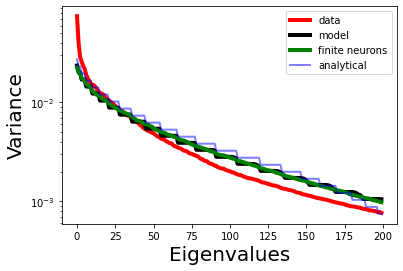

In [20]:
# eigevalues
eval_data /= np.sum(eval_data)
eval_model /= np.sum(eval_model)
eval_sampled_neurons /= np.sum(eval_sampled_neurons)
eval_anal /= np.sum(eval_anal)

t = 200
fig = plt.figure()
plt.semilogy(np.flip(eval_data)[:t], lw=4, c='r', label='data')
plt.semilogy(np.flip(eval_model)[:t], lw=4, c='k', label='model')
plt.semilogy(np.flip(eval_sampled_neurons)[:t], lw=4, c='g', label='finite neurons')
plt.semilogy(np.flip(eval_anal)[:t], lw=2, c='b', alpha=0.5, label='analytical')
plt.legend()
# plt.ylim(1e-4, 1e-1)
plt.xlabel('Eigenvalues', fontsize=20)
plt.ylabel('Variance', fontsize=20)

print('Data: %d evecs explain %0.2f variance' % (t, np.sum(eval_data[-t:])))
print('Model: %d evecs explain %0.2f variance' % (t, np.sum(eval_model[-t:])))
print('Sampled neurons: %d evecs explain %0.2f variance' % (t, np.sum(eval_sampled_neurons[-t:])))
# plt.savefig('results/V1_data/cov_mat_eigvals_Marius_DHT.pdf')

#### Plot eigenfunctions from all 4 (data, model, sampled neurons, analytical)

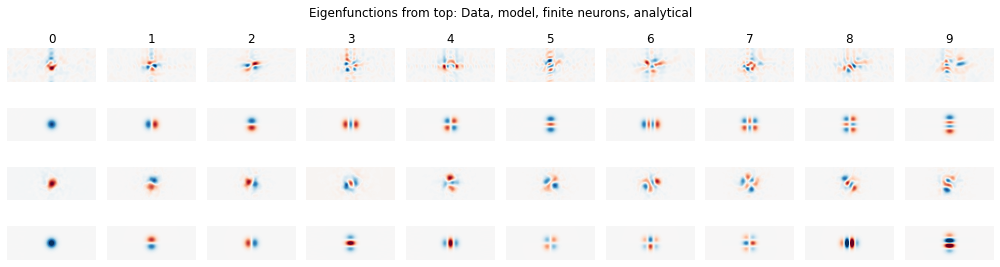

In [21]:
# plot eigenfunctions from all 4 (data, model, finite sample, analytical)
fig = plt.figure(figsize=(14, 4))
plt.suptitle('Eigenfunctions from top: Data, model, finite neurons, analytical')
for i in range(10):
    ax = fig.add_subplot(4, 10, i + 1)
    plt.imshow(evec_data[:, -i-1].reshape(30, 80), cmap='RdBu')
    plt.title(i)
    plt.clim(-0.2, 0.2)
    plt.axis('off')
    
    ax = fig.add_subplot(4, 10, 10 + i + 1)
    plt.imshow(evec_model[:, -i-1].reshape(60, 160), cmap='RdBu')
    plt.clim(-0.1, 0.1)
    plt.axis('off')
    
    ax = fig.add_subplot(4, 10, 20 + i + 1)
    plt.imshow(evec_sampled_neurons[:, -i - 1].reshape(60, 160), cmap='RdBu')
    plt.clim(-0.1, 0.1)
    plt.axis('off')
    
    ax = fig.add_subplot(4, 10, 30 + i + 1)
    plt.imshow(evec_anal[i].reshape(300, 800), cmap='RdBu')
    plt.clim(-0.8, 0.8)
    plt.axis('off')
    
plt.tight_layout()
plt.subplots_adjust(top=0.9)
# plt.savefig('results/V1_data/cov_mat_eigvecs_Marius_DHT.pdf')

### Use normality tests and qq-plot to check whether the data is normal

In [22]:
from scipy import stats
from scipy.spatial import distance
from data_fns import load_V1_Marius
from sklearn.decomposition import PCA

data_dir = 'data/V1_data_Marius/'
rf_data, snr, dim = load_V1_Marius_DHT(data_dir, centered=True, normalized=False)
rf = rf_data[snr > 1]

# whiten the dataset
rf = (rf - np.mean(rf, axis=0)) / np.std(rf, axis=0)
pca = PCA(whiten=True)
rf = pca.fit_transform(rf)

# calculate the mahalanobis distance for every point
mean = np.mean(rf, axis=0).reshape(1, -1)
dist = distance.cdist(rf, mean, 'mahalanobis') ** 2

# calculate the theoretical quantiles w.r.t. chi squared distribution
(theoretical_q, empirical_q), (slope, intercept, r) = stats.probplot(dist.flatten(), dist=stats.chi2, sparams=dim[0] * dim[1])
t = np.arange(np.min(theoretical_q), np.max(theoretical_q), 0.5)
y = slope * t + intercept # best fit line

# calculate the cdf and pdf of real data
pdf_data, bins_data = np.histogram(dist, bins=100, density=True)
bin_size_data = bins_data[1] - bins_data[0]
cdf_data = np.cumsum(pdf_data * bin_size_data)

# calculate the cdf and pdf of chi squared distribution
chi_rv = stats.chi2.rvs(dim[0] * dim[1], size=rf.shape)
pdf_chi, bins_chi = np.histogram(chi_rv, bins=100, density=True)
bin_size_chi = bins_chi[1] - bins_chi[0]
cdf_chi = np.cumsum(pdf_chi * bin_size_chi)

/home/bpandey/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Wilkes-Shapiro test: ws statistic: 0.99, p-value 0.00. Data is normal? False


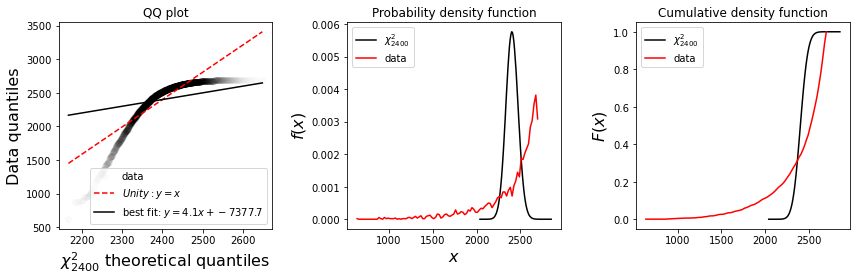

In [24]:
# perform the WS test
ws, pval = stats.shapiro(rf)
normal = True if pval > 0.05 else False 
print('Wilkes-Shapiro test: ws statistic: {:.2f}, p-value {:.2f}. Data is normal? {}'.format(ws, pval, normal))

fig = plt.figure(figsize=(12, 4))
# plot the qq-plot
ax = fig.add_subplot(131)
plt.title('QQ plot')
plt.plot(theoretical_q, empirical_q, 'ko', alpha=0.02, label='data')
plt.plot(t, y, 'r--', label=r'$Unity: y=x$')
plt.plot(t, t, 'k-', label=r'best fit: $y={:.1f}x + {:.1f}$'.format(slope, intercept))
plt.legend()
plt.xlabel(r'$\chi^2_{%d}$ theoretical quantiles' % (dim[0] * dim[1]), fontsize=16)
plt.ylabel('Data quantiles', fontsize=16)

# plot pdf
ax = fig.add_subplot(132)
plt.title('Probability density function')
plt.plot(bins_chi[1:], pdf_chi, 'k-', label=r'$\chi^2_{%d}$' % (dim[0] * dim[1]))
plt.plot(bins_data[1:], pdf_data, 'r-', label='data')
plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$f(x)$', fontsize=16)
plt.legend()

# plot cdf
ax = fig.add_subplot(133)
plt.title('Cumulative density function')
plt.plot(bins_chi[1:], cdf_chi, 'k-', label=r'$\chi^2_{%d}$' % (dim[0] * dim[1]))
plt.plot(bins_data[1:], cdf_data, 'r-', label='data')
plt.ylabel(r'$x$', fontsize=16)
plt.ylabel(r'$F(x)$', fontsize=16)
plt.legend()

plt.tight_layout()
plt.savefig('results/V1_data/normality_tests/qq_plot_Marius_DHT.pdf')